In [1]:
%reset
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# Calling Functions of Interest
import optosim.sde_solver as sde_solver
import optoanalysis as oa
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from scipy.stats import norm
from time import time
import matplotlib.animation as anim

In [3]:
#Constants
T_0 = 300 # [k], Starting Temperature
radius = 50e-9 # [m], radius of the particle 
rhoSi02 = 2600 # [kg/m^3], density of particle 
m = rhoSi02*4/3*np.pi*radius**3 # [kg], mass of the particle
kB = 1.38e-23 # J/K

# Physical Parameters/Quanitities
Gamma0 = 6000 # Damping [radians/second]
Omega0 = 100e3*2*np.pi # Trap Frequency[radians/second]
alpha = 5e7  #nonlinearity
deltaGamma = 1e3 #Cooling Rate
x0 = np.sqrt((kB*T_0)/(m*Omega0**2)) # mean displacement at temperature T_0

#Simulation Parameters
dt = 1e-8  #increments
TimeTuple=[0, 10e-3]  #time range 
t = np.arange(TimeTuple[0], TimeTuple[1], dt)
timelen = len(t)

# Pulse Parameters
NoOfPulses = 3  # Number of pulses
PulseDepth = 0.99   # Depth of Pulse
t0 = TimeTuple[1]/2   # starting position of pulse


In [4]:
# -----------------------
# SIMULATION RUN
# -----------------------

# Simulation Parameters
RunNumber = 500

# Empty Matrix Generation
ssq = np.zeros(timelen) # sum of squared q
P_array = np.zeros((RunNumber,timelen))
Q_array = np.zeros((RunNumber,timelen))
# beforePulseArray = []

for n in range(0,RunNumber):
# This loop takes a random starting state (q0,p0), and inputs into the solver 
# in addition to the static simulation parameters. 
# Afterwhich, the solver spits out (sim1.q,sim1.p)
#     print((n+1)/RunNumber*100,'%')
    print("{:.0f}%".format((n+1)/RunNumber*100),end="\r")
    q0 = np.random.normal(0,x0)
    v0 = np.random.normal(0,x0*Omega0)    
#     Simulation Solve
    sim1 = sde_solver.sde_solver(Omega0, Gamma0, q0 = q0, v0 = v0,deltaGamma = deltaGamma, mass = m, dt=dt, TimeTuple=TimeTuple)
    sim1.add_optimal_squeezing_pulses(t0, PulseDepth, NoOfPulses)
    sim1.solve()
#     Appending Q,V matrix
    Q_array[n] = sim1.q
    P_array[n] = sim1.v
#     RMS Generation
    ssq += sim1.q**2 #

msq = ssq/RunNumber # mean of squared q
rmsq = np.sqrt(msq) # root mean squared of q

In [5]:
# Selecting Desired Time Slots for before and after Pulses
t_before = t0-150e-6 # 150 us before squeezing pulse - should be thermal state
t_justAfterPulse = (t0+(NoOfPulses*sim1.PulseLength)+(NoOfPulses-1)*sim1.TimeBetweenPulses)
t_after = t_justAfterPulse + (2/2)*1/(2*Omega0/2/np.pi) 

(0.0048000000000000004, 0.0052)

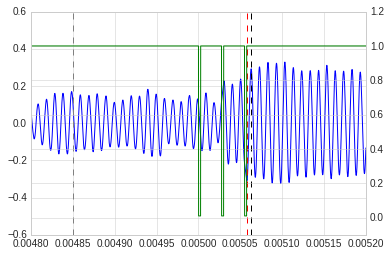

In [6]:
fig, ax1 = plt.subplots()
D = 0.0002
ax1.plot(t, 1e6*sim1.q)
plt.axvline(t_before, ls='--', color='grey')
plt.axvline(t_justAfterPulse, ls='--', color='red')
plt.axvline(t_after, ls='--', color='black')
ax2 = ax1.twinx()
ax2.plot(t, sim1.SqueezingPulseArray, 'green')
ax2.set_ylim([-0.1, 1.2])
ax1.set_xlim(0.005-D, 0.005+D)

(0.0048000000000000004, 0.0052)

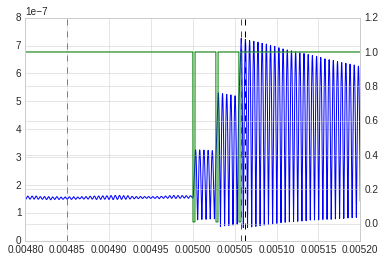

In [7]:
fig, ax1 = plt.subplots()
D = 0.0002
ax1.plot(t, rmsq)
plt.axvline(t_before, ls='--', color='grey')
plt.axvline(t_justAfterPulse, ls='--', color='red')
plt.axvline(t_after, ls='--', color='black')
ax2 = ax1.twinx()
ax2.plot(t, sim1.SqueezingPulseArray, 'green')
ax2.set_ylim([-0.1, 1.2])
ax1.set_xlim(0.005-D, 0.005+D)


/home/ash/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:11: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ash/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ash/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/ash/anaconda2/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


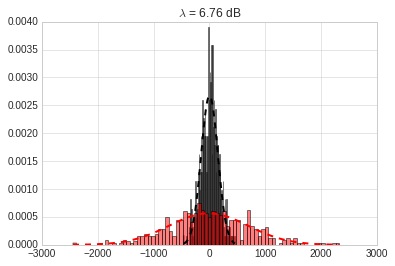

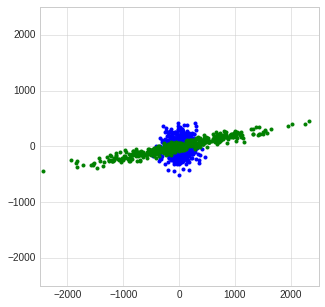

In [8]:
# # Selecting Desired Time Slots for before and after Pulses
# t_before = t0-150e-6 # 150 us before squeezing pulse - should be thermal state
# t_justAfterPulse = (t0+(NoOfPulses*sim1.PulseLength)+(NoOfPulses-1)*sim1.TimeBetweenPulses)
# t_after = t_justAfterPulse + (2/2)*1/(2*Omega0/2/np.pi) 

# Histogram Fitting Parameters
nbins = 75

rmsq = np.sqrt(rmsq/len(rmsq)) 
# Defining X,V 
x = Q_array[:, t_after/dt]*1e9
v = P_array[:, t_after/dt]/Omega0*1e9
# Defining X_initial,V_initial i..e before pulse
x_init = Q_array[:, t_before/dt]*1e9
v_init = P_array[:, t_before/dt]/Omega0*1e9

# best fit of the X_init
muX0, sigmaX0 = norm.fit(x_init)
n, bins, patches = plt.hist(x_init,nbins,normed=1,facecolor = 'grey', alpha = 0.5);
y0 = mlab.normpdf( bins, muX0, sigmaX0) # Line of best fit

# best fit of the X
muX, sigmaX = norm.fit(x)
nX, binsX, patchesX = plt.hist(x,nbins,normed=1,facecolor = 'red', alpha = 0.5);
y = mlab.normpdf( binsX, muX, sigmaX) # Line of best fit

plt.plot(binsX,y,'r--',linewidth = 2)
plt.plot(bins,y0,'k--',linewidth = 2)
plt.grid(True)
plt.title('$\lambda$ = %.2f dB' %(np.abs(10*np.log10((sigmaX/sigmaX0)))))
plt.show()

fig3, ax3 = plt.subplots(figsize=(5,5))
ax3.plot(x_init,v_init,'.')
ax3.plot(x,v,'.')
ax3.set_xlim((-2500,2500))
ax3.set_ylim((-2500,2500))
plt.show()

/home/ash/anaconda2/envs/python3/lib/python3.5/site-packages/matplotlib/artist.py:221: MatplotlibDeprecationWarning: This has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  warnings.warn(_get_axes_msg, mplDeprecation, stacklevel=1)


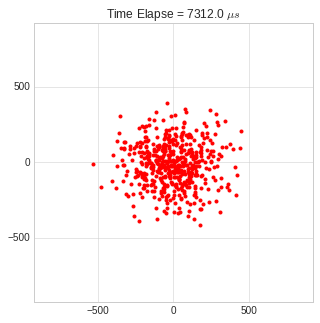

In [13]:
FFMpegWriter = anim.writers['imagemagick']
writer = FFMpegWriter(fps=200)

fig = plt.figure(figsize=(5,5))
l, = plt.plot([],[],'r.')

plt.xlim(-np.std(Q_array)*1e9*5,np.std(Q_array)*1e9*5)
plt.ylim(-np.std(Q_array)*1e9*5,np.std(Q_array)*1e9*5)

tend = t_after + (900/2)*1/(2*Omega0/2/np.pi)
start = int(np.round(t_after/dt))
# end = start+50000 #int(np.round((t_after+1/Omega0/2/np.pi)/dt))
end = int(np.round(tend/dt))
intervals = 50
k = 0
elaTime=sim1.tArray.get_array()*1e6
#filename = "/home/muddassar/Dropbox/Projects/Research/Squeezing/_img/Sim-alpha=%.f-beta=%.f-deltaGamma=%.f-Gamma0=%.f.mp4" %(alpha,beta,deltaGamma,Gamma0)
filename = "test.mp4"
with writer.saving(fig, filename,100):
    for i in range(start,end,intervals):
        k += 1
        print("{:.0f}%".format(k/((end-start)/intervals)*100),end="\r")
        x0 =  Q_array[:, i]*1e9
        y0 =  P_array[:, i]*1e9/Omega0
        l.set_data(x0,y0)
        ax = l.get_axes()
        ax.set_title('Time Elapse = %.1f $\mu s$' %(elaTime[i])) 
        writer.grab_frame()  
